In [1]:
from pipeline import Pipeline
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="Pikurrot/yolo11n-licenseplates", filename="yolo11n_licenseplates.pt")
pipeline = Pipeline(model_path)

/home/eric/miniconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device cuda


In [2]:
segments = pipeline("images/reduced/")


image 1/12 /media/eric/D/repos/ANPR-GIA/images/reduced/0.jpg: 384x640 1 license_plate, 67.3ms
image 2/12 /media/eric/D/repos/ANPR-GIA/images/reduced/1.jpg: 384x640 1 license_plate, 13.6ms
image 3/12 /media/eric/D/repos/ANPR-GIA/images/reduced/10.jpeg: 480x640 1 license_plate, 33.5ms
image 4/12 /media/eric/D/repos/ANPR-GIA/images/reduced/11.jpeg: 640x480 1 license_plate, 30.5ms
image 5/12 /media/eric/D/repos/ANPR-GIA/images/reduced/2.jpg: 288x640 1 license_plate, 31.9ms
image 6/12 /media/eric/D/repos/ANPR-GIA/images/reduced/3.jpg: 288x640 1 license_plate, 12.1ms
image 7/12 /media/eric/D/repos/ANPR-GIA/images/reduced/4.jpg: 288x640 1 license_plate, 12.7ms
image 8/12 /media/eric/D/repos/ANPR-GIA/images/reduced/5.jpg: 384x640 1 license_plate, 14.3ms
image 9/12 /media/eric/D/repos/ANPR-GIA/images/reduced/6.jpg: 480x640 1 license_plate, 9.5ms
image 10/12 /media/eric/D/repos/ANPR-GIA/images/reduced/7.jpg: 640x640 1 license_plate, 12.0ms
image 11/12 /media/eric/D/repos/ANPR-GIA/images/reduced

In [3]:
from PIL import Image
import os
import matplotlib.pyplot as plt

filenames = os.listdir("images/reduced/")
orig_images = [Image.open(f"images/reduced/{filename}") for filename in filenames]

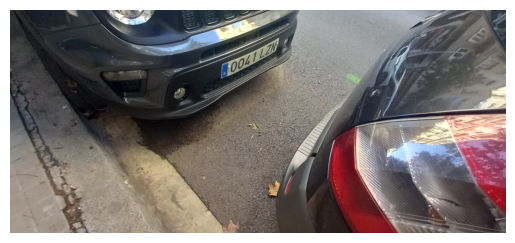

In [4]:
i = 11
plt.imshow(orig_images[i])
plt.axis("off")
plt.show()

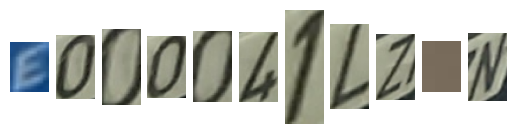

In [5]:
segments0 = segments[i][0]
fig, ax = plt.subplots(1, len(segments0))
for s, segment in enumerate(segments0):
	ax[s].imshow(segment)
	ax[s].axis("off")
plt.show()

---

In [2]:
from tqdm import tqdm
import logging
import numpy as np
from paddleocr import PaddleOCR
logging.getLogger("ppocr").setLevel(logging.ERROR)

In [3]:
detections = pipeline.detect("DatasetTotal/Frontal/", 640, 0.25, -1)
crops = pipeline.extract_boxes(detections)


image 1/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0129KMK.jpg: 288x640 1 license_plate, 63.7ms
image 2/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0195JHM.jpg: 576x640 1 license_plate, 31.6ms
image 3/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0225JWL.jpg: 640x480 1 license_plate, 31.4ms
image 4/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0226MPP.jpg: 640x480 1 license_plate, 8.4ms
image 5/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0278KXW.jpg: 544x640 1 license_plate, 32.6ms
image 6/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0304FWK.jpg: 448x640 1 license_plate, 33.4ms
image 7/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0425KDK_.jpg: 640x480 (no detections), 9.7ms
image 8/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0492MTT.jpg: 640x640 1 license_plate, 12.1ms
image 9/69 /media/eric/D/repos/ANPR-GIA/DatasetTotal/Frontal/0550HNN.jpg: 640x640 2 license_plates, 12.0ms
image 10/69 /media/eric/D/repos/ANPR-GIA/Data

In [4]:
paddleocr_reader = PaddleOCR(use_angle_cls=True, lang='en')

In [6]:
from typing import List, Tuple
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt

# Segment function updated to use the trained model for character recognition
def segment(
			source: List[List[Image.Image]]
	) -> Tuple[List[List[List[Image.Image]]], List[List[List[Image.Image]]], List[List[List[Tuple[Image.Image, str]]]]]:
	"""
	Segment the license plates into individual characters and visualize bounding boxes.

	:param source: Output of the extract_boxes function
	:return: Segments of license plates, visualizations of detected bounding boxes before and after filtering, and final segments with recognized characters.
	"""
	segments = []
	visualizations = []
	recognized_characters = []

	for img in tqdm(source):
		img_segments = []
		img_visualizations = []
		img_recognized = []
		for plate in img:
			path, plate = plate.values()
			plate_segments = []
			plate_visualizations = []
			plate_recognized = []
			
			# Resize the plate to a consistent size
			plate = plate.resize((200, 50))
			
			# Convert to grayscale if not already
			if plate.mode != "L":
				gray = plate.convert("L")
			else:
				gray = plate.copy()
			gray = np.array(gray)
			
			# Preprocess using adaptive thresholding
			blurred = cv2.GaussianBlur(gray, (5, 5), 0)
			thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
			
			# Invert the thresholded image to ensure white text on black background
			thresh = cv2.bitwise_not(thresh)
			
			# Find contours
			contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
			hierarchy = hierarchy[0]
			
			# Create an initial visualization with all bounding boxes
			original_visualization = plate.convert("RGB")
			draw = ImageDraw.Draw(original_visualization)
			for contour in contours:
				x, y, w, h = cv2.boundingRect(contour)
				draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
			plate_visualizations.append(original_visualization)
			
			# Filter contours to remove obvious noise, but retain characters and possible extra regions
			bounding_boxes = []
			for i, contour in enumerate(contours):
				x, y, w, h = cv2.boundingRect(contour)
				aspect_ratio = w / float(h)
				area = w * h
				parent_idx = hierarchy[i][3]
				child_idx = hierarchy[i][2]
				
				# Use relative area to filter contours after resizing plate to a consistent size
				if 0.1 < aspect_ratio < 2.0 and 70 < area < 800:
					# Check if the contour is not a hole (i.e., not a child of another character)
					# and if it has no children or its children are significantly smaller
					is_valid_character = True
					if parent_idx != -1:
						# If this contour is a child, it might be a hole, so skip it
						continue
					if child_idx != -1:
						# Iterate over all children and check their area
						while child_idx != -1:
							child_area = cv2.contourArea(contours[child_idx])
							if child_area > 0.5 * area:
								# If the child area is significant, this means it might not be a hole
								is_valid_character = False
								break
							child_idx = hierarchy[child_idx][0]  # Get the next child
					
					if is_valid_character:
						bounding_boxes.append((x, y, w, h))
			
			# Create a visualization after initial filtering
			filtered_visualization = plate.convert("RGB")
			draw = ImageDraw.Draw(filtered_visualization)
			for x, y, w, h in bounding_boxes:
				draw.rectangle([x, y, x + w, y + h], outline="green", width=1)
			plate_visualizations.append(filtered_visualization)
			
			# Sort from left to right
			bounding_boxes = sorted(bounding_boxes, key=lambda box: box[0])
			
			# Step 2: Apply the trained model to recognize characters in each segment
			for x, y, w, h in bounding_boxes:
				segment = plate.crop((x, y, x + w, y + h))
				r = w / h
				new_w, new_h = 60, 80
				segment = segment.resize((new_w-20, new_h-20))
				segment_orig = np.array(segment)
				segment = segment.convert("L")

				# binarialize the image
				before = segment.copy()
				_, segment = cv2.threshold(np.array(segment), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
				segment = Image.fromarray(segment)

				# place the segment on a black background slightly larger than the original
				background = Image.new('L', (new_w, new_h), 255)
				offset = (10, 10)
				background.paste(segment, offset)
				segment = background     

				# Predict with PaddleOCR
				ocr_result = paddleocr_reader.ocr(
					np.array(segment),
					det=False,
					rec=True,
					cls=False
				)
				ocr_result = {
					"text": [res[0] for res in ocr_result[0]],
					"conf": [res[1]*100 for res in ocr_result[0]]
				}
				
				# Filter based on confidence
				# try:
				# 	ocr_result['conf'][0]
				# except:
					# plt.imshow(segment)
					# plt.show()
				confidences = [float(conf) for conf in ocr_result['conf']]
				
				# Filter blue segments (E parts)
				segment_orig = cv2.cvtColor(segment_orig, cv2.COLOR_RGB2HSV)
				lower_blue = np.array([100, 50, 50])
				upper_blue = np.array([140, 255, 255])
				blue_mask = cv2.inRange(segment_orig, lower_blue, upper_blue)
				blue_pixel_count = cv2.countNonZero(blue_mask)
				total_pixel_count = segment_orig.shape[0] * segment_orig.shape[1]
				blue_ratio = blue_pixel_count / total_pixel_count
				is_blue = blue_ratio > 0.5

				# Filter blobs
				eroded = 255 - np.array(segment)
				eroded = cv2.erode(eroded, np.ones((3, 3)), iterations=8)
				is_blob = np.count_nonzero(eroded) / (new_w*new_h) > 0.05

				if confidences and max(confidences) >= -1 and not is_blue and not is_blob:
					recognized_text = ocr_result['text'][np.argmax(confidences)].strip()
					plate_segments.append(segment)
					plate_recognized.append((segment, recognized_text, max(confidences), ocr_result, before))
			
			img_segments.append(plate_segments)
			img_visualizations.append(plate_visualizations)
			img_recognized.append({"recog": plate_recognized, "path": path})
		segments.append(img_segments)
		visualizations.append(img_visualizations)
		recognized_characters.append(img_recognized)
	return segments, visualizations, recognized_characters

segments, visualizations, recognized_characters = segment(crops)

# Visualization script for debugging
def visualize_bounding_boxes(visualizations: List[List[List[Image.Image]]]):
	for img_vis in visualizations:
		for plate_vis in img_vis:
			for vis in plate_vis:
				plt.imshow(vis)
				plt.show()

100%|██████████| 69/69 [00:17<00:00,  3.90it/s]


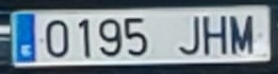

In [7]:
crops[1][0]["box"]

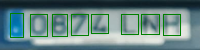

In [21]:
visualizations[11][0][1]

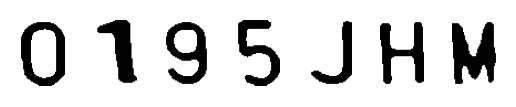

In [9]:
segments[1][0]
fig, ax = plt.subplots(1, len(segments[1][0]))
fig.subplots_adjust(wspace=0.1)  # Add horizontal space between images
for j, segment in enumerate(segments[1][0]):
	ax[j].imshow(segment, cmap="gray", vmin=0, vmax=255)
	ax[j].axis("off")
plt.show()

In [9]:
# visualize_bounding_boxes(visualizations)

In [13]:
# [len(s) for s in segments],# [len(s[0]) for s in segments]

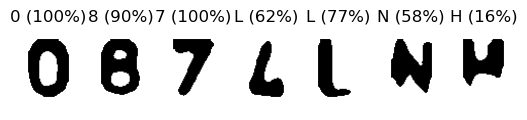

In [20]:
i = 11

fig, ax = plt.subplots(1, len(recognized_characters[i][0]["recog"]))
for j, (segment, character, confidence, ocr_result, before) in enumerate(recognized_characters[i][0]["recog"]):
	ax[j].imshow(segment, cmap="gray", vmin=0, vmax=255)
	if character:
		ax[j].set_title(f"{character} ({confidence:.0f}%)")
	else:
		ax[j].set_title("?")
	ax[j].axis("off")
plt.show()

In [21]:
import re
recognized_text = "".join([character for _, character, _, _, _ in recognized_characters[i][0]["recog"]])
formatted_text = re.sub(r'(?<=\d)(?=[A-Za-z])|(?<=[A-Za-z])(?=\d)', ' ', recognized_text)
formatted_text

'0129 KMK'

In [27]:
recognized_characters[i][0]["path"]

'/media/eric/D/repos/ANPR-GIA/Test/Frontal/9892JFR.jpg'

In [14]:
import os
predictions = []
gt = [img[0]["path"].split("/")[-1].split(".")[0] if len(img)>0 else "-------" for img in recognized_characters]
for i, img in enumerate(crops):
	if len(recognized_characters[i]) == 0:
		recognized_text = ""
	else:
		recognized_text = "".join([character for _, character, _, _, _ in recognized_characters[i][0]["recog"]])
	predictions.append(recognized_text)
predictions[:5], gt[:5]

(['0129KMK', '0195JHM', '0225JL', '0226MPP', '0278KXW'],
 ['0129KMK', '0195JHM', '0225JWL', '0226MPP', '0278KXW'])

In [15]:
# compute edit distance
from Levenshtein import distance

def compute_similarity_percentage(predictions, gt):
    similarities = []
    for pred, true in zip(predictions, gt):
        d = distance(pred, true)
        max_len = max(len(pred), len(true))
        if max_len > 0:
            similarity = (1 - d / max_len) * 100  # Convert to percentage
        else:
            similarity = 100.0  # Both strings are empty
        similarities.append(similarity)
    
    average_similarity = sum(similarities) / len(similarities) if similarities else 0
    return similarities, average_similarity

similarities, average_similarity = compute_similarity_percentage(predictions, gt)
average_similarity

84.02921555095466

In [19]:
p = 15
print(predictions[:p])
print(gt[:p])

['0129KMK', '0195JHM', '0225JL', '0226MPP', '0278KXW', '0304FWK', '', '0492TT', '0550HNN', '0649DSH', '0804CZV', '087LLNH', '1062FNT', '1111LRB', '']
['0129KMK', '0195JHM', '0225JWL', '0226MPP', '0278KXW', '0304FWK', '-------', '0492MTT', '0550HNN', '0649DHS', '0804CZV', '0874LNH', '1062FNT', '1111LRB', '1310MPK']


In [16]:
similarities

[100.0,
 100.0,
 85.71428571428572,
 100.0,
 100.0,
 100.0,
 0.0,
 85.71428571428572,
 100.0,
 71.42857142857143,
 100.0,
 85.71428571428572,
 100.0,
 100.0,
 0.0,
 85.71428571428572,
 100.0,
 100.0,
 71.42857142857143,
 85.71428571428572,
 100.0,
 85.71428571428572,
 14.28571428571429,
 77.77777777777779,
 85.71428571428572,
 42.85714285714286,
 100.0,
 100.0,
 100.0,
 25.0,
 71.42857142857143,
 85.71428571428572,
 100.0,
 85.71428571428572,
 85.71428571428572,
 85.71428571428572,
 85.71428571428572,
 87.5,
 100.0,
 87.5,
 100.0,
 100.0,
 77.77777777777779,
 85.71428571428572,
 100.0,
 87.5,
 100.0,
 100.0,
 85.71428571428572,
 100.0,
 85.71428571428572,
 100.0,
 85.71428571428572,
 77.77777777777779,
 100.0,
 100.0,
 75.0,
 100.0,
 85.71428571428572,
 100.0,
 44.44444444444444,
 14.28571428571429,
 66.66666666666667,
 85.71428571428572,
 62.5,
 100.0,
 100.0,
 100.0,
 100.0]

---

In [1]:
from pipeline import Pipeline
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="Pikurrot/yolo11n-licenseplates", filename="yolo11n_licenseplates.pt")
pipeline = Pipeline(model_path)
result = pipeline("DatasetTotal/Above/")

[2024/10/12 14:03:22] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/eric/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/eric/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length

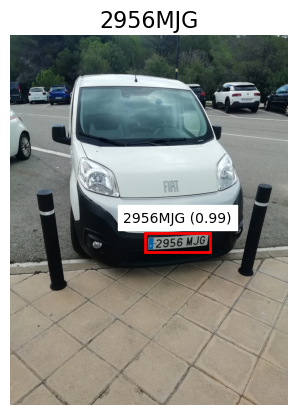

In [2]:
pipeline.plot_result(result[3])